# **Классификация объявлений**

Постановка задачи: дан датасет объявлений, необходимо предсказать, имеются ли в объявлении контактные данные.

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 8.2MB 4.7MB/s 


In [ ]:
# Отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")

# Основные библиотеки
import numpy as np
import pandas as pd

# Отрисовка шкалы прогресса
from tqdm import tqdm
tqdm.pandas()

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)

# Обработка текста
import re     
import nltk
nltk.download("stopwords")
import pymorphy2
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer    

# Предобработка
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectFromModel

# Машиное обучение
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

# Подключение Google Drive
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Так как данных довольно много, будем загружать датасет с гугл диска.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Предварительный анализ и обработка пропусков

Загрузим данные и посмотрим на них.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_ADV.csv')

In [ ]:
data.head(5)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0


В таблице содержатся: название объявления, сам текст объявления, категория и подкатегория, поставленная цена, регион и город размещения, временная метка размещения объявления. Колонка is_bad является целевой и указывает на то, является ли объявление плохим (т.е. содержит контактные данные человека).

В датасете 984487 строк и 9 столбцов.



In [ ]:
data.shape

(984487, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984487 entries, 0 to 984486
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               984487 non-null  object 
 1   description         984487 non-null  object 
 2   subcategory         984487 non-null  object 
 3   category            984487 non-null  object 
 4   price               926439 non-null  float64
 5   region              984487 non-null  object 
 6   city                984487 non-null  object 
 7   datetime_submitted  984487 non-null  object 
 8   is_bad              984487 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 67.6+ MB


В столбце price имеются пропущенные значения. Так как данных довольно много, пропуски можно просто удалить.

In [ ]:
data = data[data.price.notna()]

In [ ]:
data.shape

(926439, 9)

Посмотрим на целевой столбец. Данные не сбалансированы.

In [ ]:
data.is_bad.value_counts()

0    711271
1    215168
Name: is_bad, dtype: int64

Столбец с датой объявления нужно преобразовать к формату datetime.

In [ ]:
data.datetime_submitted = pd.to_datetime(data.datetime_submitted)

## Извлечение дополнительных признаков

Из колонки datetime_submitted выделим временные признаки (год, месяц и т.д)

In [ ]:
#data['year'] = data.datetime_submitted.dt.year                                                     # Год (все данные представлены за 2019)
data['month'] = data.datetime_submitted.dt.month                                                    # Месяц
data['day'] = data.datetime_submitted.dt.day                                                        # День
data['weekday'] = data.datetime_submitted.dt.weekday                                                # День недели
data['is_weekend'] = data.weekday.apply(lambda x: 1 if x in (5, 6) else 0)                          # Выходной или нет
data['hour'] = data.datetime_submitted.dt.hour                                                      # Час
data['minute'] = data.datetime_submitted.dt.minute                                                  # Минуты
data['is_morning'] = data.hour.apply(lambda x: 1 if x in (6,7,8,9,10,11,12) else 0)                 # Утро
data['is_afternoon'] = data.hour.apply(lambda x: 1 if x in (13,14,15,16,17,18,19,20,21,22) else 0)  # Вечер
data['length'] = data.description.apply(lambda x: len(x))                                           # Длина строки объявления
data['numbers'] = data.description.apply(lambda x: len(re.findall(r'\b\d+\b', x)))                  # Количество цифр 
data['len_title'] = data.title.apply(lambda x: len(x))                                              # Длина строки названия
data['num_title'] = data.title.apply(lambda x: len(re.findall(r'\b\d+\b', x)))                      # Количество цифр в названии
data['plus'] = data.description.apply(lambda x: len(re.findall( r'\+', x)))                         # Количество символов +
data['dog'] = data.description.apply(lambda x: len(re.findall( r'\@', x)))                          # Количество символов @

In [ ]:
data.head(5)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,month,day,weekday,is_weekend,hour,minute,is_morning,is_afternoon,length,numbers,len_title,num_title,plus,dog
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0,6,1,5,1,0,0,0,0,256,2,13,0,0,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0,6,1,5,1,0,0,0,0,741,6,39,2,0,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1,6,1,5,1,0,0,0,0,223,2,29,1,0,0
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1,6,1,5,1,0,0,0,0,493,1,33,0,0,0
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0,6,1,5,1,0,0,0,0,64,0,16,0,0,0


Перед дальнейшим извлечением признаков немного предобработаем датасет: удалим мусорные символы и эмодзи.

In [ ]:
data[data.is_bad ==1].description.iloc[6987]

'Наша Фабрика производит аккордеоны !/\n✅они у нас на металлокаркассе /\n✅с ортопедическими ламелями под матрасом/\n✅матрас пружинный / или латексированный пенополиуретан марки HR ( на выбор) /\n✅бельевой ящик входит в цену/\n✅отстрочка: квадрат/или ромб ( на выбор )/\n✅чехол- съемный/\n ✅4 вида модных подлокотников на выбор. См в профиле другие аккордеоны./\n✅6000 вариантов тканей/\n✅размер спального места : /\n/\n80*605- 28.500₽/\n620*605-29.900₽/\n640*200-22.000₽/\n610*200-31.000₽/\n680*200-38.000₽/\n/\n🌹🌹🌹мы предлагаем только Красивые, Антивандальные ткани!/\n/\n☝️И да! У нас самые адекватные цены!!! Проверено🌹 🤩и у нас есть фабричный магазин, где вы можете убедиться во всем вышеизложенном лично. Адрес в шапке профиля.☝️☝️☝️./\n./\n🤑размер дивана как на фото - 610*605, спальное место - 620*200/\nДорогая ткань- антивандальная ткань с очень красивым ливанским принтом./\n/\n❤️❤️❤️❤️❤️подписывайся на наш профиль, чтобы не пропустить новинки и большие скидки !!!!!!! Зайди обязательно в 

In [ ]:
data.description = data.description.str.replace("\n", " ").apply(lambda x: x.lower()) # заменяем переносы строк на пробелы и приводим к строчному виду  
data.description = data.description.str.replace("/", " ")               
data.description = data.description.apply(lambda x: re.sub(r'[^a-zа-яё0-9\s\+\-\.\@\_]', '', x))       # удаляем мусорные символы
data.description = data.description.apply(lambda x: re.sub(r'\s+', ' ', x))                       # удаляем лишние пробелы

In [ ]:
data[data.is_bad ==1].description.iloc[6987]

'наша фабрика производит аккордеоны они у нас на металлокаркассе с ортопедическими ламелями под матрасом матрас пружинный или латексированный пенополиуретан марки hr на выбор бельевой ящик входит в цену отстрочка квадрат или ромб на выбор чехол- съемный 4 вида модных подлокотников на выбор. см в профиле другие аккордеоны. 6000 вариантов тканей размер спального места 80605- 28.500 620605-29.900 640200-22.000 610200-31.000 680200-38.000 мы предлагаем только красивые антивандальные ткани и да у нас самые адекватные цены проверено и у нас есть фабричный магазин где вы можете убедиться во всем вышеизложенном лично. адрес в шапке профиля.. . размер дивана как на фото - 610605 спальное место - 620200 дорогая ткань- антивандальная ткань с очень красивым ливанским принтом. подписывайся на наш профиль чтобы не пропустить новинки и большие скидки зайди обязательно в профиль '

Очистка прошла хорошо.


Посмотрим, какие контактные данные могут быть в объявлениях.
Это могут быть:
* Ссылки на ВК (vk.com, id)
* Ссылки н другие соцсети (Discord, Skype, What's App(вотсап,вацап), Instagram)
* Номер телефона (+79, 89, 79, звонить, тел, телефон, звоните, по номеру, по телефону,номер), даже словами
* Адрес (режим работы, улица)
* Сайт (.ru, .com, .рф)
* Электронная почта

In [ ]:
data[data.is_bad ==1].description.iloc[np.random.randint(0, len(data[data.is_bad ==1].description))]

'звоните 8-982-238-35-94 8-943-158-30-47 на все интересующие вопросы отвечу машина в хорошем состоянииторг есть'

In [ ]:
Soсial = ['vk','\sвк\s','вконтакте','id','instagram','инстаграм','инстаграмм','вибер','вайбер','viber','whats','вотсап','вотсап','discord','skype','telegram','телеграм']
Telephone = ['тел','звонить','телефон','звоните','номер','номеру','телефону','восемь','семь','девять','девятьсот']
Adress = ['\sул\s','улица','улице','адрес','адресу','дом']
Site = ['\.ru','com','\.рф','gmail','mail','bk','biz','\.ру','https','http']

In [ ]:
# Bool есть или нет
data['social'] = np.where(data.description.apply(lambda x: re.findall(r"(?=("+'|'.join(Soсial)+r"))", x)),1,0)
data['phone'] = np.where(data.description.apply(lambda x: re.findall(r"(?=("+'|'.join(Telephone)+r"))", x)),1,0)  
data['adress'] = np.where(data.description.apply(lambda x: re.findall(r"(?=("+'|'.join(Adress)+r"))", x)),1,0)  
data['site'] = np.where(data.description.apply(lambda x: re.findall(r"(?=("+'|'.join(Site)+r"))", x)),1,0)
data['phone_number'] = np.where(data.description.apply(lambda x: re.findall( r'^((8|\+7)[\- ]?)?(\(?\d{3}\)?[\- ]?)?[\d\- ]{7,10}$' , x)),1,0)


# Подсчет количества
#data['social'] = data.description.apply(lambda x: len(re.findall(r"(?=("+'|'.join(Soсial)+r"))", x)))
#data['telephone'] = data.description.apply(lambda x: len(re.findall(r"(?=("+'|'.join(Telephone)+r"))", x)))  
#data['adress'] = data.description.apply(lambda x: len(re.findall(r"(?=("+'|'.join(Adress)+r"))", x)))  
#data['site'] = data.description.apply(lambda x: len(re.findall(r"(?=("+'|'.join(Site)+r"))", x)))  

## Визуальный анализ

Категориальные признаки:

In [ ]:
сategorical = ['subcategory', 'category', 'region', 'month', 'day', 'weekday',
        'is_weekend', 'hour', 'minute', 'is_morning', 'is_afternoon', 'social',
        'telephone', 'adress', 'site']

post_time = ['month', 'day', 'weekday','is_weekend', 'hour', 'minute', 'is_morning', 'is_afternoon']
data_features = ['subcategory', 'category', 'region','city']
is_bad_cols = ['social','phone', 'adress', 'site']

Для изначальных данных видно, например, что для категорий Услуги и Животные большая доля плохих объявлений.

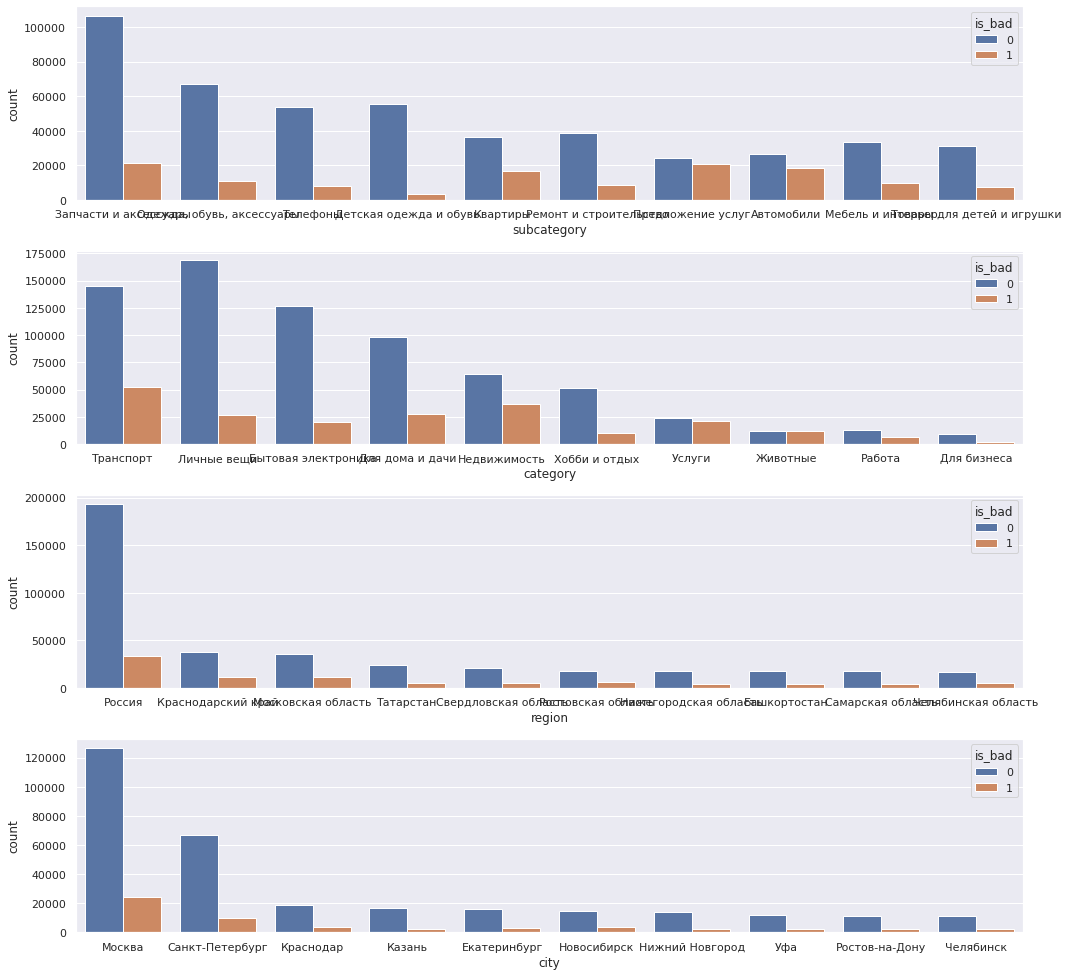

In [ ]:
plt.figure(figsize = (15,20))
for idx,col in enumerate(data[data_features]):
    plt.subplot(6,1,idx+1)
    sns.countplot(x=data[col], hue=data.is_bad, order = data[col].value_counts()[:10].index)
    plt.tight_layout()
None

Время, в которое было выложено объявление, не влияет.

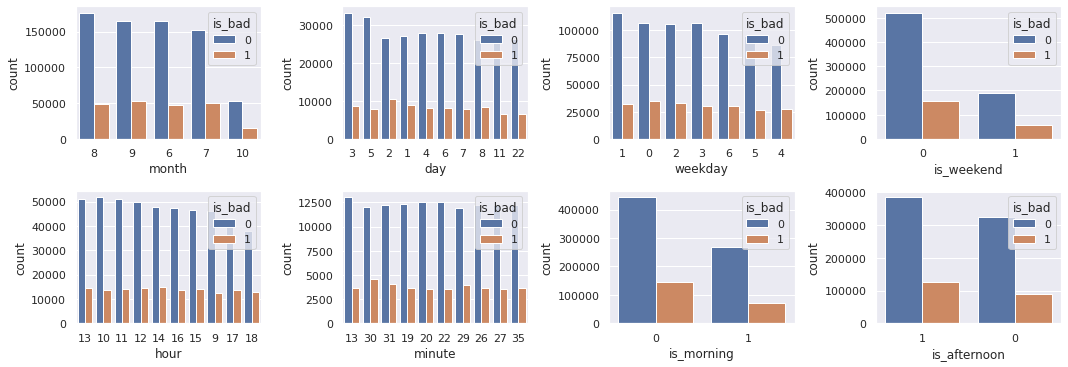

In [ ]:
plt.figure(figsize = (15,15))
for idx,col in enumerate(data[post_time]):
    plt.subplot(6,4,idx+1)
    sns.countplot(x=data[col], hue=data.is_bad, order = data[col].value_counts()[:10].index)
    plt.tight_layout()
None

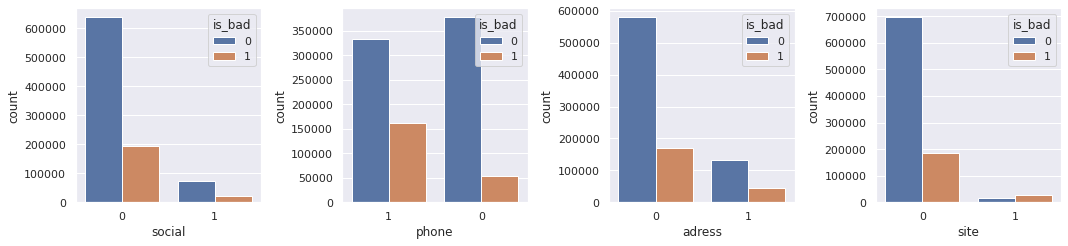

In [ ]:
plt.figure(figsize = (15,20))
for idx,col in enumerate(data[is_bad_cols]):
    plt.subplot(6,4,idx+1)
    sns.countplot(x=data[col], hue=data.is_bad, order = data[col].value_counts()[:10].index)
    plt.tight_layout()
None

Посмотрим, какие данные у нас получились.

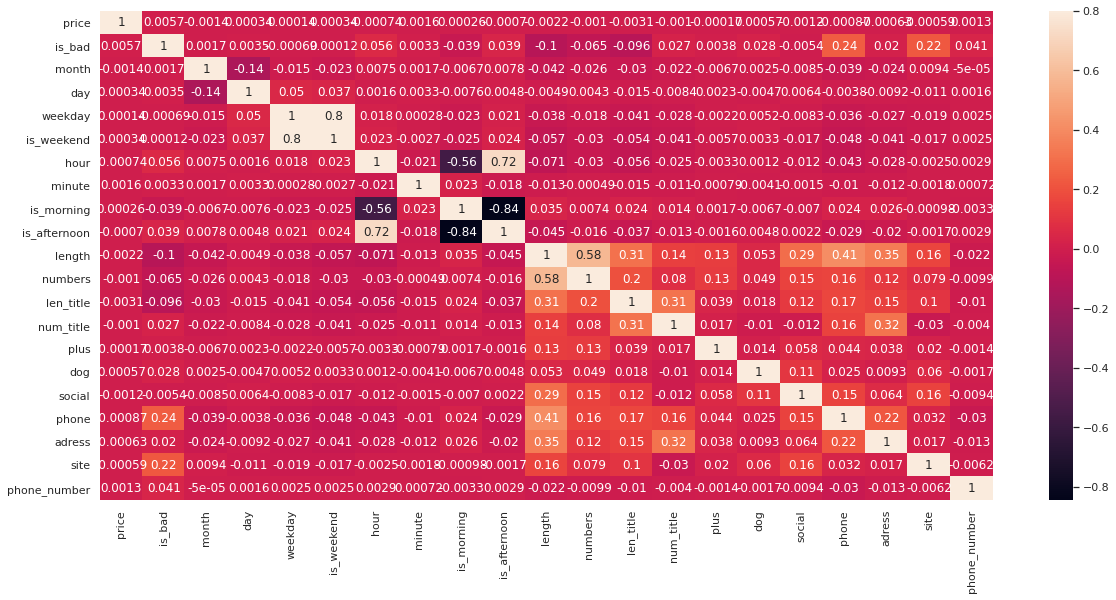

In [ ]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True)

## Лемматизация текстовых колонок

In [ ]:
text_cols = ['title','description']

Надо привести все слова к нормальной форме, для этого удалим все символы, кроме букв.

In [ ]:
def clear_text(df, column):
    df[column] =  df[column].apply(lambda x: x.lower()).apply(lambda x: re.sub(r'[^a-zа-яё\s]', ' ', x))
    df[column] =  df[column].apply(lambda x: re.sub(r'\s+', ' ', x)) 

In [ ]:
for col in text_cols:
    data.col = clear_text(data, col)

In [ ]:
data.description.iloc[np.random.randint(0, len(data.description))]

'тренажер новый пользовался раз от силы продаю потому что под моим весом кг он раздражающе скрипит в спортмастере такой стоит sportmaster ru product забирать из академгородка '

In [ ]:
data.title.iloc[np.random.randint(0, len(data.title))]

'айфон с'

In [ ]:
russian_stopwords = stopwords.words("russian") # стоп-слова, которые не будут использоваться при лемматизации
morph = pymorphy2.MorphAnalyzer()

In [ ]:
russian_stopwords[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
def lemmatize(text):
    text = " ".join( morph.parse(word)[0].normal_form for word in text.split() if len(word)>1 and word not in russian_stopwords)
    return text

In [ ]:
lemmatised_desc = data.description.progress_apply(lambda x: lemmatize(x))

In [ ]:
lemmatised_tit = data.title.progress_apply(lambda x: lemmatize(x))

100%|██████████| 926439/926439 [07:52<00:00, 1961.06it/s]


In [ ]:
# Сохраним, чтобы потом не пересчитывать
lemmatised_desc.to_csv('lemma3.csv')
lemmatised_tit.to_csv('lemma_title')

In [ ]:
lemmatised_desc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lemma1.csv', index_col=0)

In [ ]:
lemmatised_desc.shape

(926439, 1)

In [ ]:
lemmatised_tit.head(5)

0                        диван кровать
1         кожух рулевой колонка даф хф
2           дешёвый буста аккаунт dota
3    телевизор sharp смарт тв интернет
4                     открытка конверт
Name: title, dtype: object

## Пайплайн машинного обучения

### Модель с базовыми параметрами

Подготовим матрицу признаков и столбец ответов. Разделим их на тренировочную и тестовую выборки.

In [ ]:
data.description = lemmatised_desc.astype('U')
data.title = lemmatised_tit.astype('U')

Столбец city имеет 3309 уникальных значений, которые не особо влияют на ответ, однако удалять мы его пока не будем, потому что в дальнейшем произведем отбор признаков.

In [ ]:
data.city.nunique()

3309

In [ ]:
X = data.drop(['is_bad','datetime_submitted'], axis=1)
y = data.is_bad

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [ ]:
X_train.shape, X_test.shape

((620714, 26), (305725, 26))

Построим пайплайн машинного обучения, которй будет включать в себя трансформер колонок (one hot encoding для категориальных признаков и векторизация самого текста объявления с помощью TfidfVectorizer) и модель.

В качестве модели я приняла решение использовать XGBoost.

Так как данные не сбалансированы (плохими являются только примерно 20% объявлений), в качестве метрики будет использована roc auc, которая хорошо работает на несбалансированных данных. А также, при обучении воспользуемся undersampling'ом (на практике проверено, что это улучшает качество модели).

Подбирать гиперпараметры будем с помощью RandomizedSearchCV.

In [ ]:
cat_cols = ['subcategory', 'category', 'region','city']

transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_cols),
    (TfidfVectorizer(), 'description'),
    (TfidfVectorizer(), 'title')                            
)

In [ ]:
pipe = make_pipeline(transformer, RandomUnderSampler(random_state=42), XGBClassifier())

In [ ]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 4min 42s, sys: 1.24 s, total: 4min 43s
Wall time: 4min 43s


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['subcategory', 'category',
                                                   'region', 'city']),
                                                 ('tfidfvectorizer-1',
                                                 

In [ ]:
print('Качество на обучающей выборке = ', roc_auc_score(y_train, pipe.predict(X_train)))
print('Качество на тестовой выборке = ', roc_auc_score(y_test, pipe.predict(X_test)))

Качество на обучающей выборке =  0.8264870124938327
Качество на тестовой выборке =  0.8270775007527768


В формате вероятностей:

In [ ]:
pred =  pipe.predict_proba(X_test)[:,1]
pred_train = pipe.predict_proba(X_train)[:,1]

train_auc = roc_auc_score(y_train, pred_train)
test_auc = roc_auc_score(y_test, pred)

In [ ]:
print('Качество на обучающей выборке = ', train_auc)
print('Качество на тестовой выборке = ', test_auc)

Качество на обучающей выборке =  0.8970500762892344
Качество на тестовой выборке =  0.8958462742730033


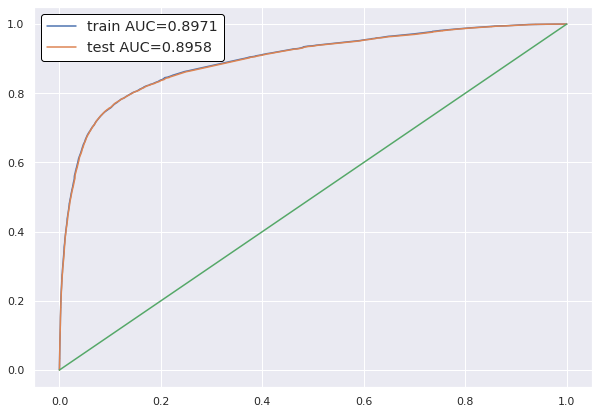

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, pred_train)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, pred)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Видно, что модель практически не переобучается, однако хотелось бы достичь более хорошего результата.

Построим график, чтобы посмотреть, какие признаки оказались наиболее важные.

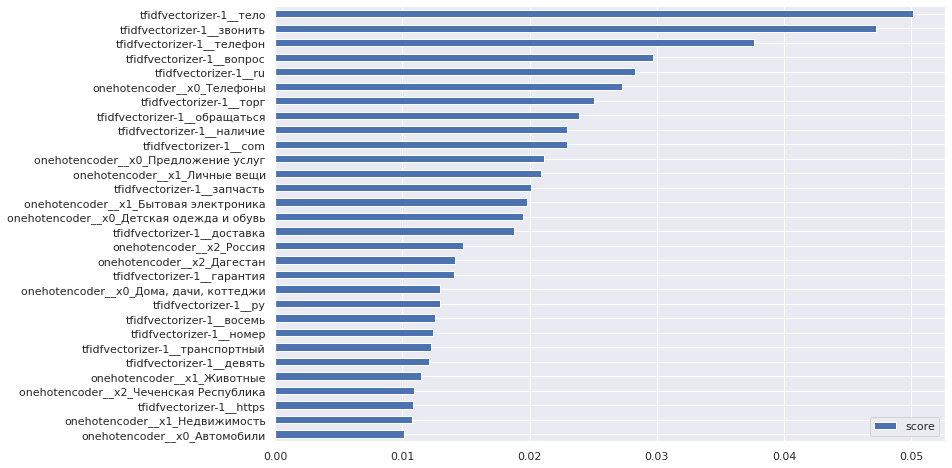

In [ ]:
impotrance = pd.DataFrame(data=pipe[2].feature_importances_,index=pipe[0].get_feature_names(),columns=["score"]).sort_values(by = "score").tail(30)

fig, ax = plt.subplots(1,1,figsize=(12,8))
impotrance.plot(kind='barh', ax=ax)

### Выбор признаков

В получившемся датасете 591471 признаков и некоторые из них не сильно влияют на модель или не влияют вообще.

In [ ]:
print("Количество признаков =",len(pipe[2].feature_importances_))

Количество признаков = 591471


In [ ]:
# Количество уникальных значений (ненулевые +1)
len(sorted(list(set(pipe[2].feature_importances_))))

171

Подберем порог, по которому будем отсекать мало информативные признаки.

In [ ]:
thresholds = sorted(list(set(pipe[2].feature_importances_)))[67:73]
for thresh in tqdm(thresholds):
	# select features using threshold
	selection = SelectFromModel(pipe[2], threshold=thresh)
	new_pipe = make_pipeline(transformer, selection, RandomUnderSampler(random_state=42) ,XGBClassifier())
	new_pipe.fit(X_train, y_train)
	# eval model
	predictions = new_pipe.predict(X_test)
	auc = roc_auc_score(y_test, predictions)
	print(f"Threshold={thresh:.5f}, n={len(new_pipe[3].feature_importances_)}, Roc Auc: {auc:.5f}")

 17%|█▋        | 1/6 [10:02<50:12, 602.57s/it]

Threshold=0.00142, n=105, Roc Auc: 0.82725


 33%|███▎      | 2/6 [19:59<40:03, 600.86s/it]

Threshold=0.00145, n=105, Roc Auc: 0.82725


 50%|█████     | 3/6 [29:54<29:57, 599.17s/it]

Threshold=0.00146, n=104, Roc Auc: 0.82699


 67%|██████▋   | 4/6 [39:31<19:44, 592.34s/it]

Threshold=0.00147, n=104, Roc Auc: 0.82699


 83%|████████▎ | 5/6 [49:01<09:45, 585.83s/it]

Threshold=0.00154, n=103, Roc Auc: 0.82674


100%|██████████| 6/6 [58:34<00:00, 585.72s/it]

Threshold=0.00155, n=103, Roc Auc: 0.82674


Оптимальный порог:

In [ ]:
threshold = 0.00145

Для хорошей работы модели хватает всего 105 признаков.

### Подбор гиперпараметров

In [ ]:
selection = SelectFromModel(pipe[2], threshold=threshold)

In [ ]:
params = {
        'booster':['gbtree', 'gblinear','dart'],
        'min_child_weight': [1, 3, 6],
        'subsample': [0.5, 0.7, 1],
        'max_depth': [ 8, 10],
        'n_estimators': [ 100, 150, 200],
        'learning_rate': [ 0.01, 0.1, 0.2],
        'colsample_bytree': [0.5, 0.7, 1],
        'gamma':[0, 1]
        }

In [ ]:
clf = RandomizedSearchCV(XGBClassifier(), params, n_jobs=-1, cv=3, verbose=10, refit=True, 
                         n_iter=50, scoring= 'roc_auc', random_state=42)

In [ ]:
search_pipe = make_pipeline(transformer, selection, RandomUnderSampler(random_state=42), clf)

In [ ]:
%%time
search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 48.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 74.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 97.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 116.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 128.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 144.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 169.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed

CPU times: user 20min 16s, sys: 7.03 s, total: 20min 23s
Wall time: 3h 43min 4s


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['subcategory', 'category',
                                                   'region', 'city']),
                                                 ('tfidfvectorizer-1',
                                                 

In [ ]:
best_clf = search_pipe[3].best_estimator_
best_clf 

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred_train = search_pipe.predict_proba(X_train)[:,1]
y_pred = search_pipe.predict_proba(X_test)[:,1]

In [ ]:
print('Качество на обучающей выборке = ', roc_auc_score(y_train, y_pred_train))
print('Качество на тестовой выборке = ', roc_auc_score(y_test, y_pred))

Качество на обучающей выборке =  0.9321251513450178
Качество на тестовой выборке =  0.9240934835085348


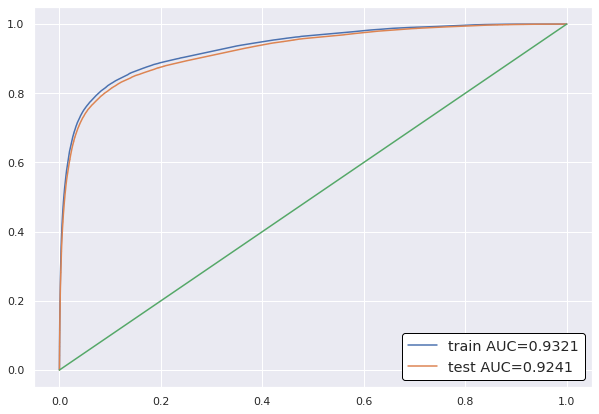

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_pred_train)[:2], label='train AUC={:.4f}'.format(roc_auc_score(y_train, y_pred_train)))
plt.plot(*roc_curve(y_test, y_pred)[:2], label='test AUC={:.4f}'.format(roc_auc_score(y_test, y_pred)))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## **Выводы**

В результате работы алгоритма XGBoost со стандартными параметрами на тестовой выборке получился результат roc_auc = 0,8958.

Отбор признаков и подбор гиперпараметров позволил улучшить этот результат до 0,9241.

Самыми весомыми признаками оказались категория и подкатегория объявления, а также такие ключевые слова, как "тело", "звонить", "телефон" и "вопрос", что видно из графика важности признаков.

Модель получилась не переобучена и в целом считаю, что она работает хорошо.